<a href="https://colab.research.google.com/github/dohun-mat/dna_study_semina/blob/main/week4_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [3]:
device

'cuda'

In [4]:
root_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1'
train_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [5]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [7]:
train_class.all_data[0]

'/content/drive/MyDrive/Colab Notebooks/dna/original-1/train/dolphin/dolphin_000.jpg'

In [131]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

img_unnormalize = A.Compose([
    A.Normalize(mean=(-0.485, -0.456, -0.406), std=(0.229,0.224, 0.225)), # 텐서타입은 안해줌
    ToTensorV2()
])


### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

In [ ]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[-2.1179, -2.1179, -2.1008,  ...,  0.6392,  0.2111, -0.1143],
         [-2.1179, -2.1179, -2.1008,  ...,  0.0912, -0.2856, -0.4054],
         [-2.1179, -2.1179, -2.1179,  ..., -0.3198, -0.4226, -0.4226],
         ...,
         [-2.0152, -2.0152, -2.0152,  ..., -1.0219, -0.9705, -1.0562],
         [-2.0152, -2.0323, -2.0323,  ..., -1.0390, -1.0904, -1.1418],
         [-2.0152, -2.0323, -2.0494,  ..., -1.1247, -1.2445, -1.1418]],

        [[-1.0553, -1.0553, -1.0553,  ...,  1.3957,  1.3081,  1.3431],
         [-1.0553, -1.0553, -1.0203,  ...,  1.2381,  1.2556,  1.4307],
         [-1.0728, -1.0378, -1.0203,  ...,  1.2556,  1.3957,  1.5882],
         ...,
         [ 0.1352,  0.2227,  0.3277,  ...,  1.6933,  1.7283,  1.6408],
         [ 0.1001,  0.1702,  0.2577,  ...,  1.6583,  1.6232,  1.5707],
         [ 0.0826,  0.1176,  0.1877,  ...,  1.5882,  1.4832,  1.5882]],

        [[-1.7870, -1.7522, -1.7522,  ...,  0.8797,  0.4788,  0.0779],
         [-1.8044, -1.7870, -1.7870,  ...,  0

In [39]:
import numpy as np 
from torchvision.transforms import ToPILImage

In [85]:
train_class[0][0].shape

torch.Size([3, 224, 224])

In [92]:
img_to_array = np.transpose(train_class[0][0],(2,1,0)) #채널축변경

In [102]:
img_to_array.shape

torch.Size([224, 224, 3])

In [132]:
augmentation = img_unnormalize(image = np.array(img_to_array))
img_unnorm = augmentation['image'] #비정규화

In [137]:
img_unnorm

tensor([[[2.1538, 2.1535, 2.1514,  ..., 2.1462, 2.1438, 2.1420],
         [2.1532, 2.1526, 2.1535,  ..., 2.1508, 2.1485, 2.1467],
         [2.1547, 2.1547, 2.1558,  ..., 2.1514, 2.1488, 2.1470],
         ...,
         [2.1491, 2.1494, 2.1494,  ..., 2.1485, 2.1488, 2.1488],
         [2.1485, 2.1491, 2.1494,  ..., 2.1491, 2.1494, 2.1494],
         [2.1485, 2.1488, 2.1494,  ..., 2.1491, 2.1494, 2.1494]],

        [[2.0678, 2.0678, 2.0666,  ..., 2.0528, 2.0510, 2.0488],
         [2.0663, 2.0666, 2.0678,  ..., 2.0580, 2.0556, 2.0534],
         [2.0678, 2.0678, 2.0693,  ..., 2.0577, 2.0556, 2.0531],
         ...,
         [2.0534, 2.0534, 2.0531,  ..., 2.0500, 2.0503, 2.0503],
         [2.0528, 2.0525, 2.0531,  ..., 2.0503, 2.0503, 2.0503],
         [2.0528, 2.0525, 2.0531,  ..., 2.0503, 2.0503, 2.0503]],

        [[1.8249, 1.8249, 1.8231,  ..., 1.8003, 1.7982, 1.7964],
         [1.8231, 1.8231, 1.8243,  ..., 1.8052, 1.8025, 1.8009],
         [1.8234, 1.8234, 1.8249,  ..., 1.8043, 1.8015, 1.

In [134]:
tensor_toPILImage = ToPILImage() 
img_PIL_from_Tensor = tensor_toPILImage(img_unnorm)

In [135]:
img_to_numpy = np.array(img_PIL_from_Tensor)

In [136]:
print(np.array(img_PIL_from_Tensor)) # 0~255
print(np.array(img_PIL_from_Tensor).shape) # 224 x 224 x 3

[[[ 37  15 209]
  [ 37  15 209]
  [ 36  14 208]
  ...
  [ 35  11 203]
  [ 34  10 202]
  [ 34  10 202]]

 [[ 37  14 208]
  [ 36  14 208]
  [ 37  15 209]
  ...
  [ 36  12 204]
  [ 35  12 203]
  [ 35  11 203]]

 [[ 37  15 208]
  [ 37  15 208]
  [ 37  15 209]
  ...
  [ 36  12 204]
  [ 35  12 203]
  [ 35  11 202]]

 ...

 [[ 36  11 201]
  [ 36  11 201]
  [ 36  11 201]
  ...
  [ 35  10 199]
  [ 35  10 199]
  [ 35  10 199]]

 [[ 35  11 201]
  [ 36  11 201]
  [ 36  11 201]
  ...
  [ 36  10 199]
  [ 36  10 199]
  [ 36  10 199]]

 [[ 35  11 201]
  [ 35  11 201]
  [ 36  11 201]
  ...
  [ 36  10 199]
  [ 36  10 199]
  [ 36  10 199]]]
(224, 224, 3)


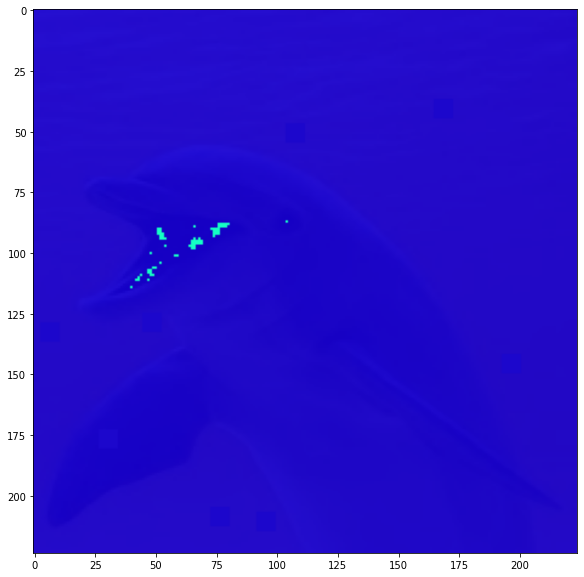

In [138]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

grid = gridspec.GridSpec(1,1)#그래프를 그릴 도화지 개수
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace= 0.4, hspace=0.4) #그래프 간의 거리 조절

ax0 = plt.subplot(grid[0])
ax0.imshow(img_to_numpy)


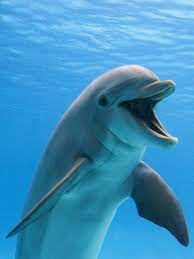

In [139]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

In [ ]:
# numpy == H W C
# tensor = C H W